# Common
## Imports

In [1]:
from platform import python_version

print(python_version())

3.7.6


In [35]:
import gym

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from IPython.display import clear_output, display

# suppress pandas warning
pd.options.mode.chained_assignment = None

# set seed
np.random.seed(0)

%matplotlib inline

# Helper Functions

In [3]:
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'k',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title='Frozen Lake'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.savefig('./frozen/' + title + '.png', dpi=400)
    
#plot_lake(env, policy)

In [4]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail


In [5]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy 

# Setup Problem

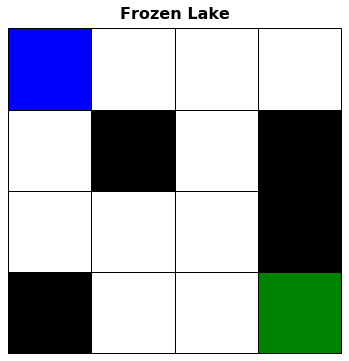

In [6]:
# Setup 4x4
env = gym.make('FrozenLake-v0').unwrapped

# Create transition and reward matrices from OpenAI P matrix
rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env)

# Value Iteration
## Function

In [7]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=100000):
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            policy = policy.reshape(4,4)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, time, iters, maxR))
            
            if showResults:
                title = 'FrozenLake_VI_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_e' + str(e)
                plot_lake(env, policy, title)
            
            testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [8]:
gammas   = [0.1, 0.3, 0.6, 0.9]
epsilons = [1e-2, 1e-3, 1e-8, 1e-12]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

#vi_data.head()

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.10,	1E-02,	0.00,	1,	0.333333
0.10,	1E-03,	0.00,	2,	0.344444
0.10,	1E-08,	0.00,	7,	0.345239
0.10,	1E-12,	0.00,	11,	0.345239
0.30,	1E-02,	0.00,	3,	0.373333
0.30,	1E-03,	0.00,	4,	0.374667
0.30,	1E-08,	0.00,	13,	0.375103
0.30,	1E-12,	0.00,	20,	0.375103
0.60,	1E-02,	0.00,	6,	0.445120
0.60,	1E-03,	0.00,	9,	0.447311
0.60,	1E-08,	0.00,	29,	0.447649
0.60,	1E-12,	0.00,	46,	0.447649
0.90,	1E-02,	0.00,	26,	0.637540
0.90,	1E-03,	0.00,	43,	0.638883
0.90,	1E-08,	0.01,	128,	0.639020
0.90,	1E-12,	0.01,	195,	0.639020


/opt/python/anaconda3-2019-03/envs/mavan/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/python/anaconda3-2019-03/envs/mavan/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/python/anaconda3-2019-03/envs/mavan/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/python/anaconda3-2019-03/envs/mavan/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/python/anaconda3-2019-03/envs/mavan/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Plots

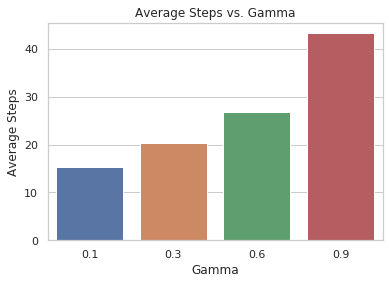

In [9]:
# Compare number of iterations with lowest epsilon

# extract the average number of steps for each gamma value
x = gammas
y = []
for g in gammas:
    y.append(vi_data.loc[vi_data['gamma'] == g]['average_steps'].mean())


sns.set(style="whitegrid")

fig = plt.figure(figsize=(6,4))
ax  = sns.barplot(x, y)
ax.set_title('Average Steps vs. Gamma')
ax.set_xlabel('Gamma')
ax.set_ylabel('Average Steps')

title='VI_averageSteps_vs_gamma'
plt.savefig('./frozen/' + title + '.png', dpi=400)


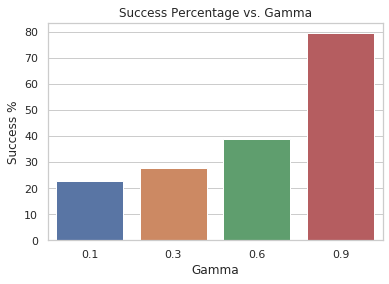

In [10]:
# Compare success of runs

# extract the average success percentage for each gamma value
x = gammas
y = []
for g in gammas:
    y.append(vi_data.loc[vi_data['gamma'] == g]['success_pct'].mean())

fig = plt.figure(figsize=(6,4))
ax  = sns.barplot(x,y)
ax.set_title('Success Percentage vs. Gamma')
ax.set_xlabel('Gamma')
ax.set_ylabel('Success %')

title='VI_successPct_vs_gamma'
plt.savefig('./frozen/' + title + '.png', dpi=400)

## Results

Best Result:
	Success = 80.30
	Gamma = 0.90
	Epsilon= 1E-03


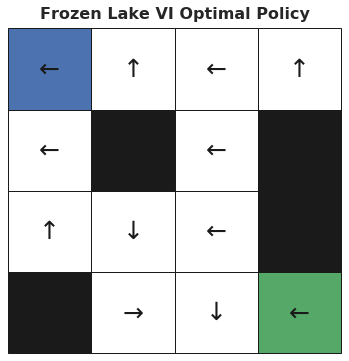

In [11]:
# Plot most successful gamma and epsilon

# find the score with the highest success percentage and get its policy
bestRun = vi_data['success_pct'].argmax()
best_policy = vi_data['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(rows, cols)

# plot the policy
title='Frozen Lake VI Optimal Policy'
plot_lake(env, best_policy, title)

# write all results to csv file
csvFile = 'frozen/VI_results.csv'
vi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f\n\tEpsilon= %.E' % (vi_data['success_pct'].max(), vi_data['gamma'][bestRun], vi_data['epsilon'][bestRun]))


# Policy Iteration
## Function

In [12]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('Gamma,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"
        
        runs  = test.run()
        time  = test.time
        iters = test.iter
        maxR  = runs[-1]['Max V']
        
        print(iters, time)
        
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        policy = np.array(test.policy)
        policy = policy.reshape(4,4)
        
        data['gamma'][testNum]        = g
        data['time'][testNum]         = time
        data['iterations'][testNum]   = iters
        data['reward'][testNum]       = maxR
        data['mean_rewards'][testNum] = {tuple(mean_rewards)}
        data['max_rewards'][testNum]  = {tuple(max_rewards)}
        data['error'][testNum]        = {tuple(errors)}
        data['policy'][testNum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, time, iters, maxR))
        
        if showResults:
            title = 'FrozenLake_PI_' + str(rows) + 'x' + str(cols) + '_g' + str(g)
            plot_lake(env, policy, title)
        
        testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

In [13]:
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pi_data  = policyIteration(T, R, gammas, showResults=False)

#pi_data.head()

Gamma,	Time,	Iter,	Reward
________________________________________________________________________________
4 0.0022573471069335938
0.10,	0.00,	4,	0.345239
4 0.0018415451049804688
0.20,	0.00,	4,	0.358992
4 0.0015006065368652344
0.30,	0.00,	4,	0.375103
4 0.0013186931610107422
0.40,	0.00,	4,	0.394332
4 0.0016579627990722656
0.50,	0.00,	4,	0.417861
4 0.0016870498657226562
0.60,	0.00,	4,	0.447649
4 0.0013170242309570312
0.70,	0.00,	4,	0.487267
5 0.0016148090362548828
0.80,	0.00,	5,	0.544196
6 0.001967906951904297
0.90,	0.00,	6,	0.639020


## Plots

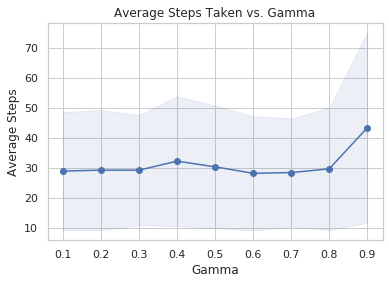

In [32]:
# Compare number of iterations with lowest epsilon

# extract the average number of steps for each gamma value
x = gammas
y = pi_data['average_steps']
sigma = pi_data['steps_stddev']

fig = plt.figure(figsize=(6,4))
plt.plot(x, y, 'o-')
plt.fill_between(x, y-sigma, y+sigma, color='b', alpha=0.1)

plt.title('Average Steps Taken vs. Gamma')
plt.xlabel('Gamma')
plt.ylabel('Average Steps')
plt.grid(True)

title='PI_averageSteps_vs_gamma'
plt.savefig('./frozen/' + title + '.png', dpi=400)

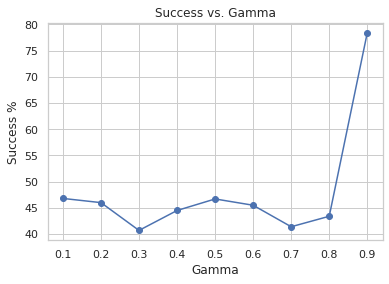

In [33]:
# Compare success of runs

# extract the average success percentage for each gamma value
x = pi_data['gamma']
y = pi_data['success_pct']

fig = plt.figure(figsize=(6,4))
plt.plot(x, y, 'o-')

plt.title('Success vs. Gamma')
plt.xlabel('Gamma')
plt.ylabel('Success %')
plt.grid(True)

title='VI_successPct_vs_gamma'
plt.savefig('./frozen/' + title + '.png', dpi=400)

## Results

Best Result:
	Success = 78.40
	Gamma = 0.90


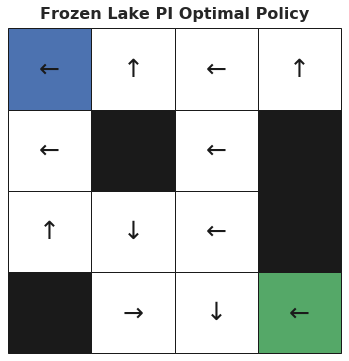

In [16]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = pi_data['success_pct'].argmax()

best_policy = pi_data['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(rows, cols)

# plot the policy
title='Frozen Lake PI Optimal Policy'
plot_lake(env, best_policy, title)

# write all results to csv file
csvFile = 'frozen/PI_results.csv'
pi_data.to_csv(csvFile)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f' % (pi_data['success_pct'].max(), pi_data['gamma'][bestRun]))

# Q-Learning

## Function

In [65]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)
    
    print('Gamma,\tAlpha,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:
                        print('Test Num %d/%d' %(testNum, numTests))
                        print('Gamma: %.2f,\tAlpha: %.2f,\tAlpha Decay:%.3f,\tEpsilon Decay:%.3f,\tIterations:%d' 
                             %(g, a, a_decay, e_decay, n))
                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        policy = np.array(test.policy)
                        policy = policy.reshape(4,4)
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}
                        
                        print('%.2f,\t%.2f,\t%.2f,\t%d,\t%f' % (g, a, time, iters, maxR))
                        
                        if showResults:
                            title = 'FrozenLake_QL_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_a' + str(a) + '_adecay' + str(a_decay) + '_edecay' + str(e_decay) + '_iter' + str(n)
                            plot_lake(env, policy, title)
                        
                        testNum = testNum + 1
            
    # See differences in policy
    policies = data['policy']
    
    for i,p in enumerate(policies):
        pol = list(p)[0]
        steps, steps_stddev, failures = get_score(env, pol, showResults)
        data['average_steps'][i] = steps
        data['steps_stddev'][i]  = steps_stddev
        data['success_pct'][i]   = 100-failures      
        
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

## Setup

Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 0/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.01,	4.84,	100000,	0.087957
Test Num 1/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.80,	0.01,	46.83,	1000000,	0.472730
Test Num 2/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000000
0.80,	0.01,	480.16,	10000000,	0.551939
Test Num 3/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.01,	4.87,	100000,	0.101924
Test Num 4/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:1000000
0.80,	0.01,	47.32,	1000000,	0.461346
Test Num 5/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:10000000
0.80,	0.01,	466.65,	10000000,	0.510185
Test Num 6/108
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsi

/opt/python/anaconda3-2019-03/envs/mavan/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Test Num 21/108
Gamma: 0.80,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.10,	4.60,	100000,	0.185699
Test Num 22/108
Gamma: 0.80,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:1000000
0.80,	0.10,	44.60,	1000000,	0.480933
Test Num 23/108
Gamma: 0.80,	Alpha: 0.10,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:10000000
0.80,	0.10,	445.02,	10000000,	0.513565
Test Num 24/108
Gamma: 0.80,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.80,	0.20,	4.53,	100000,	0.079254
Test Num 25/108
Gamma: 0.80,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.80,	0.20,	43.89,	1000000,	0.463171
Test Num 26/108
Gamma: 0.80,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000000
0.80,	0.20,	468.26,	10000000,	0.535653
Test Num 27/108
Gamma: 0.80,	Alpha: 0.20,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.80,	0.20,	5.08,	100000,	0.080877
Test Num 28/108
Gamma: 0.80,	Alpha: 0

0.99,	0.01,	449.32,	10000000,	0.629974
Test Num 81/108
Gamma: 0.99,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:100000
0.99,	0.01,	4.55,	100000,	0.058655
Test Num 82/108
Gamma: 0.99,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:1000000
0.99,	0.01,	43.79,	1000000,	0.353692
Test Num 83/108
Gamma: 0.99,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:10000000
0.99,	0.01,	441.27,	10000000,	0.689750
Test Num 84/108
Gamma: 0.99,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:100000
0.99,	0.10,	4.50,	100000,	0.029780
Test Num 85/108
Gamma: 0.99,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:1000000
0.99,	0.10,	43.97,	1000000,	0.520555
Test Num 86/108
Gamma: 0.99,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000000
0.99,	0.10,	436.45,	10000000,	0.698873
Test Num 87/108
Gamma: 0.99,	Alpha: 0.10,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:100000
0.99,	0.10,	4.45,	100000,	0.07217

----------------------------------------------
You took an average of 25 steps to get the frisbee
And you fell in the hole 77.90 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 32 steps to get the frisbee
And you fell in the hole 56.90 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 11 steps to get the frisbee
And you fell in the hole 96.00 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 14 steps to get the frisbee
And you fell in the hole 96.10 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 12 steps to get the frisbee
And you fell in the hole 92.30 % of the times
----------------------------------------------
---------------------------------------------

----------------------------------------------
You took an average of 16 steps to get the frisbee
And you fell in the hole 93.40 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 29 steps to get the frisbee
And you fell in the hole 88.90 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 14 steps to get the frisbee
And you fell in the hole 92.10 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 17 steps to get the frisbee
And you fell in the hole 94.10 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 28 steps to get the frisbee
And you fell in the hole 89.10 % of the times
----------------------------------------------
---------------------------------------------

,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0.8,0.01,0.0,0.0,100000.0,4.840734,0.087957,12.463415,5.605300,4.1,"{(2, 1, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.8,0.01,0.0,0.0,1000000.0,46.825693,0.472730,12.836735,5.640042,4.9,"{(1, 2, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 2, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.8,0.01,0.0,0.0,10000000.0,480.157838,0.551939,17.693642,8.749818,17.3,"{(1, 3, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0.8,0.01,0.0,0.0,100000.0,4.869994,0.101924,27.400000,21.265935,17.0,"{(2, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 3,...","{(0.000625, 0.000625, 0.000625, 0.000625, 0.00...","{(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0....","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0.8,0.01,0.0,0.0,1000000.0,47.322821,0.461346,24.945055,14.988906,9.1,"{(0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


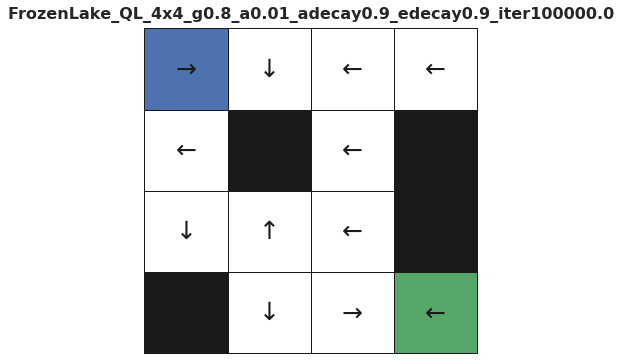

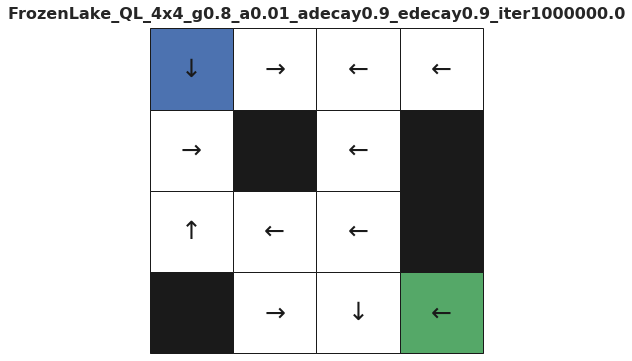

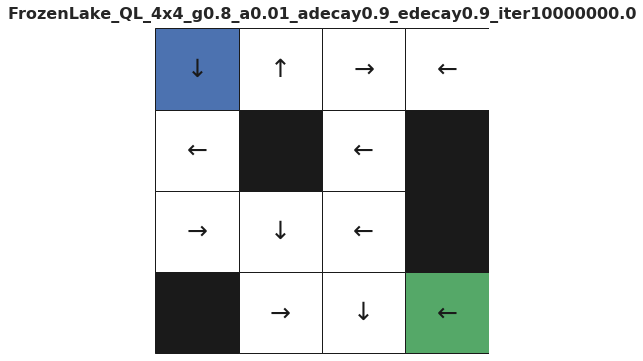

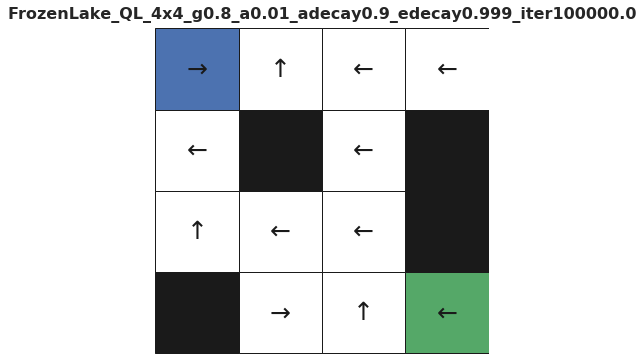

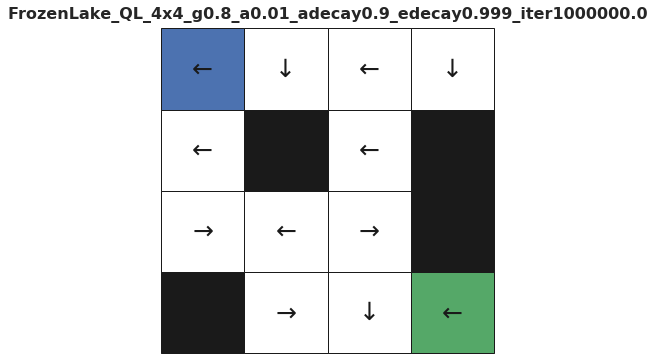

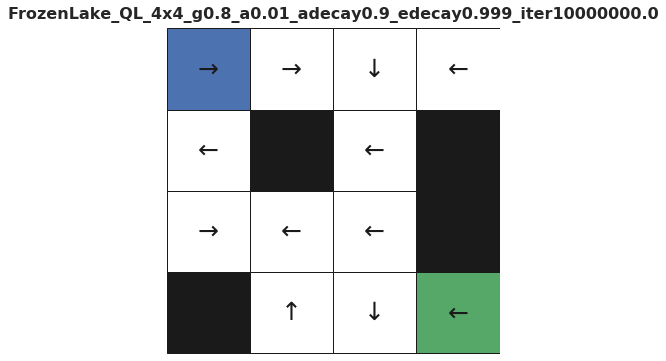

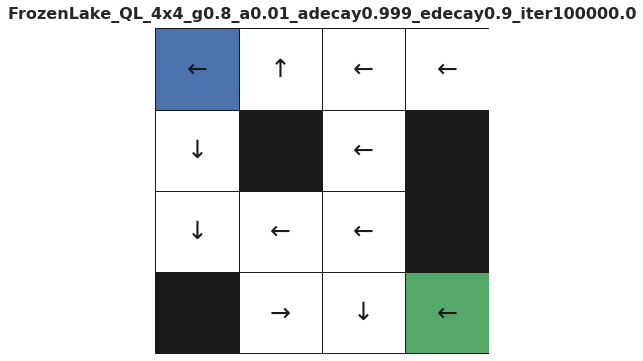

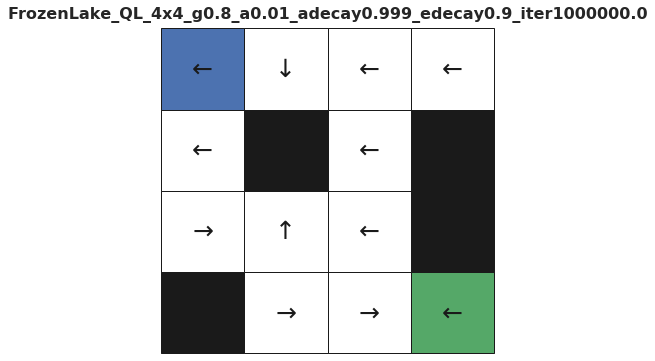

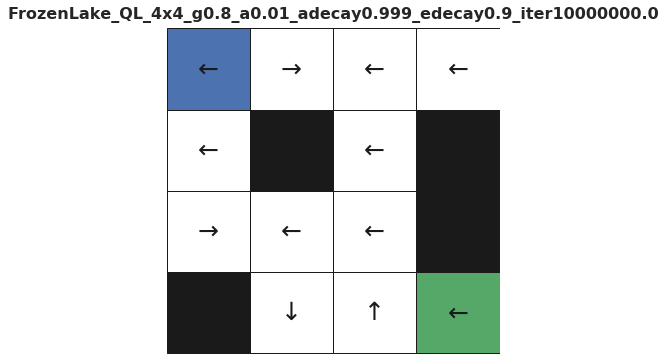

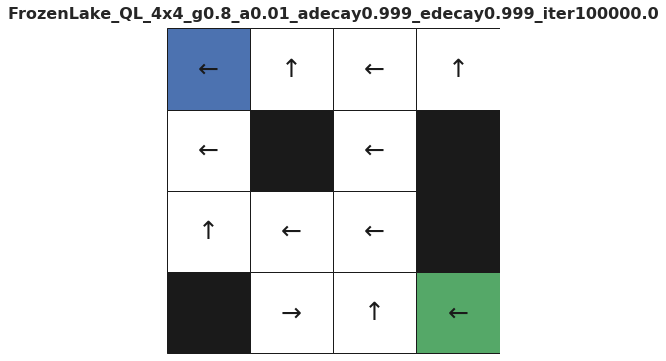

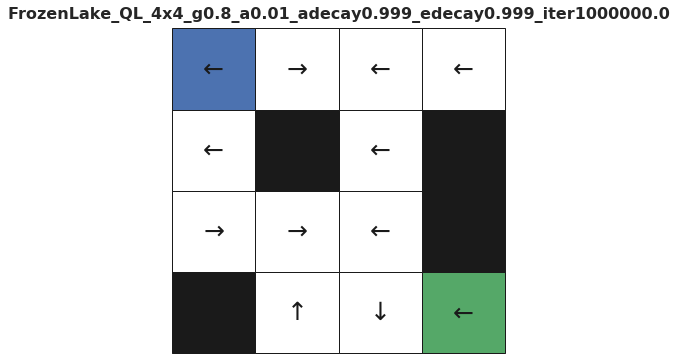

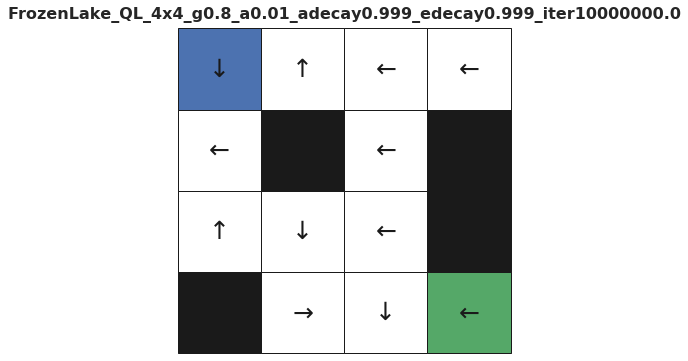

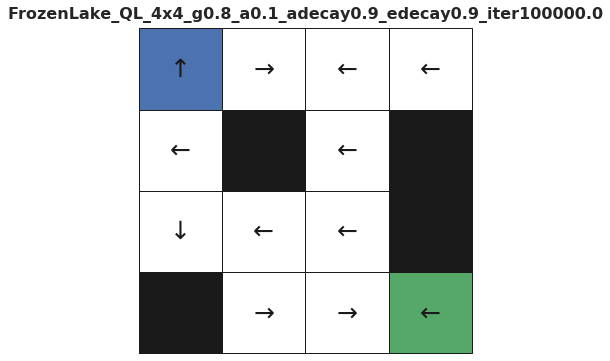

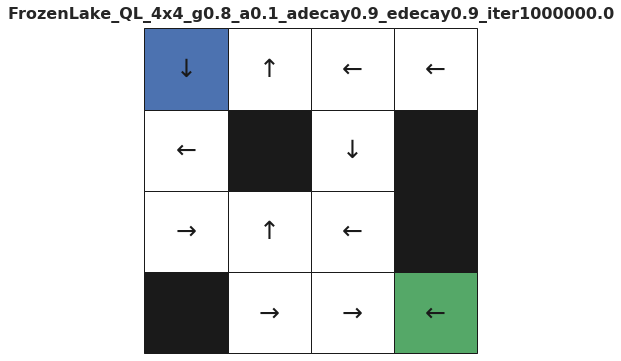

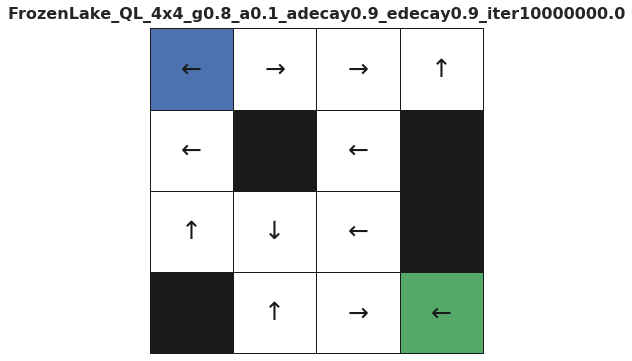

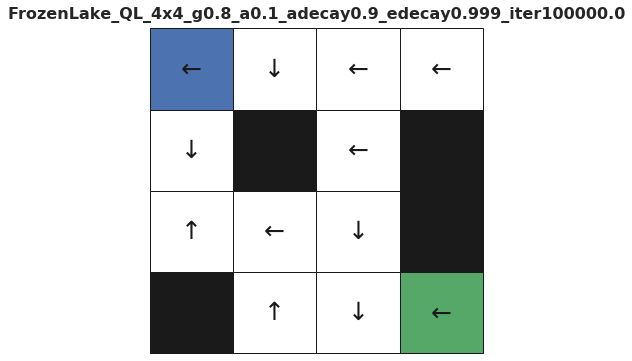

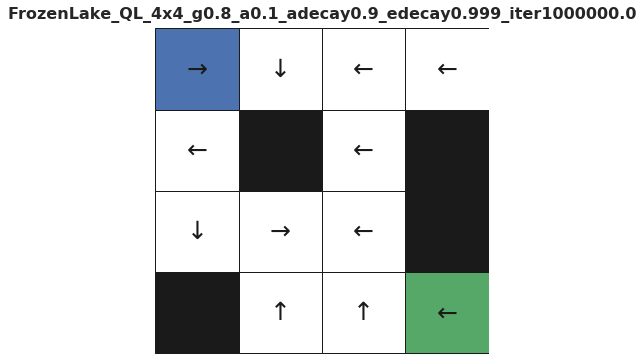

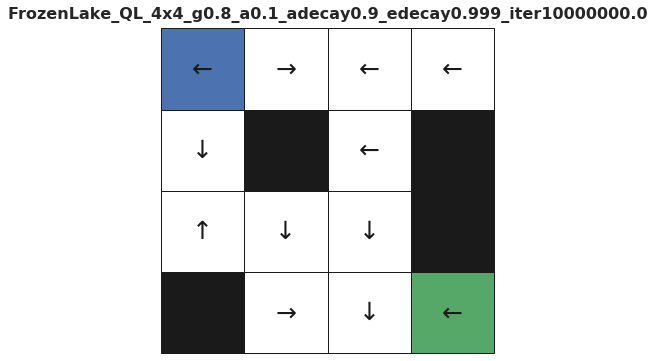

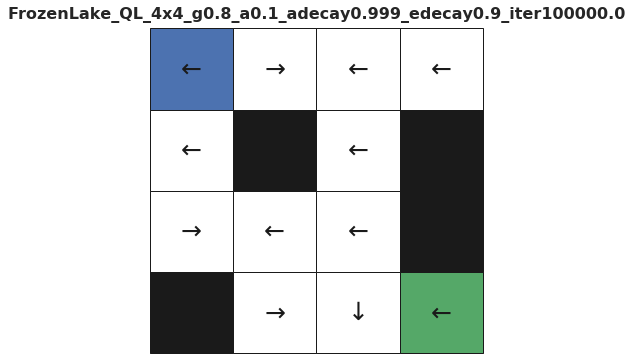

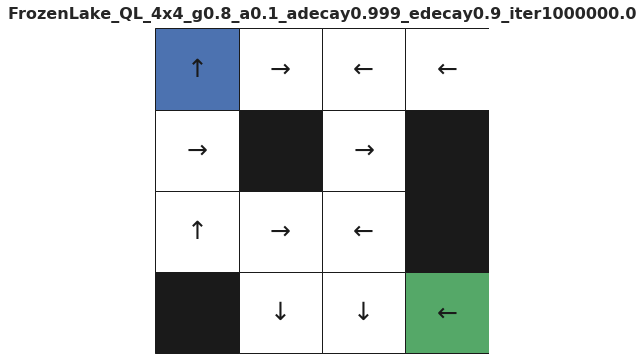

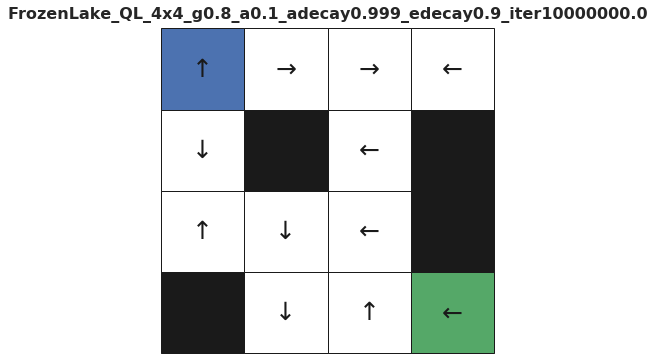

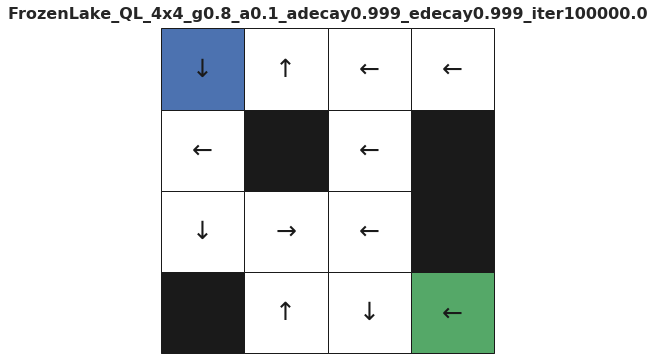

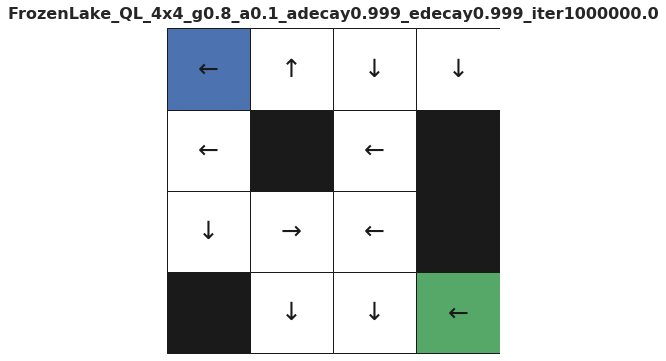

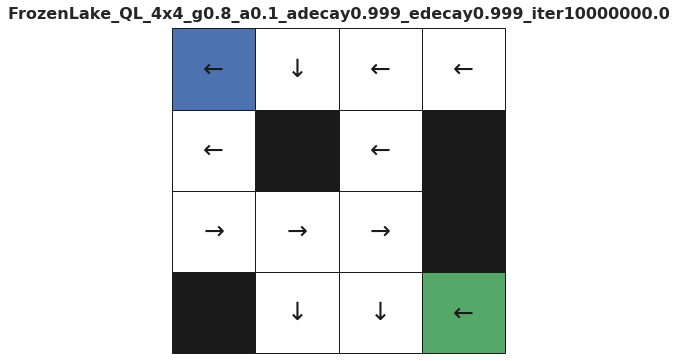

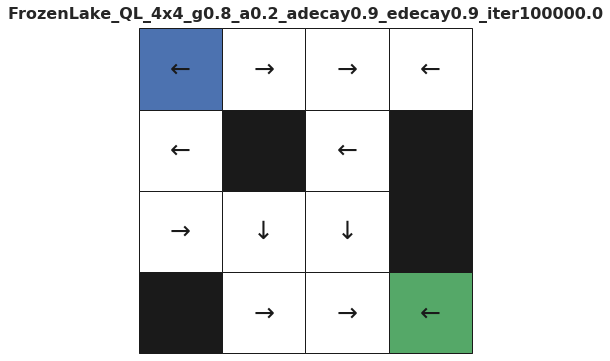

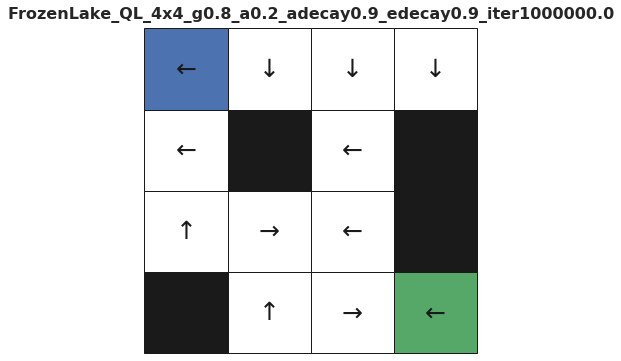

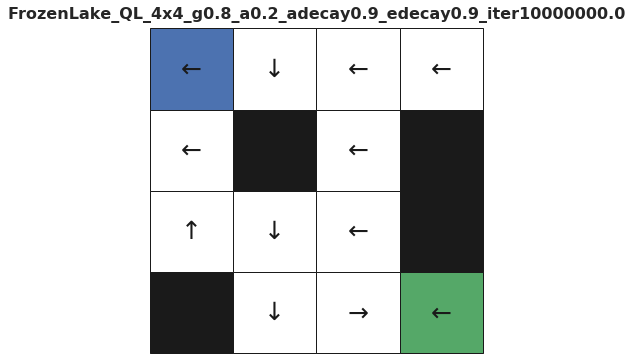

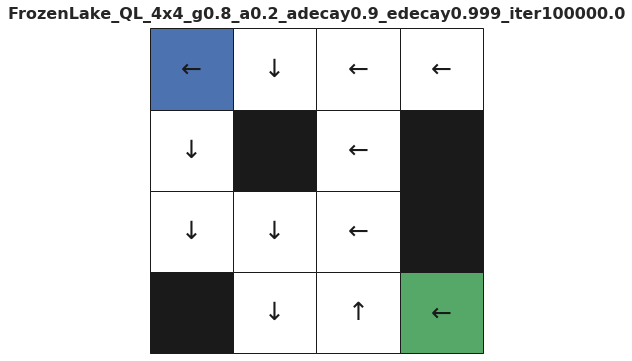

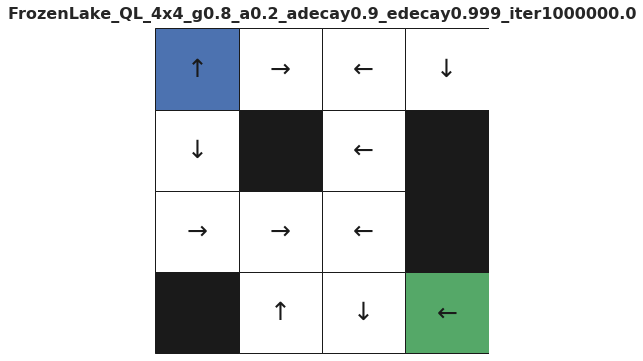

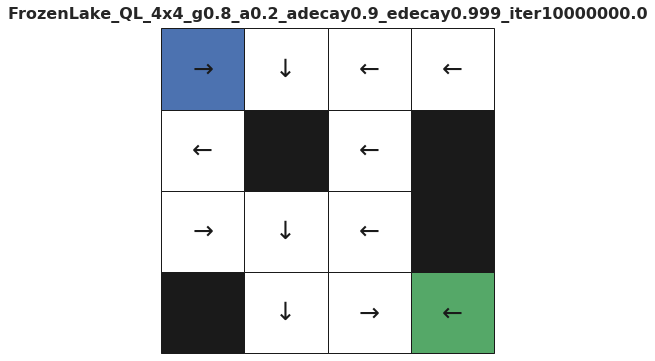

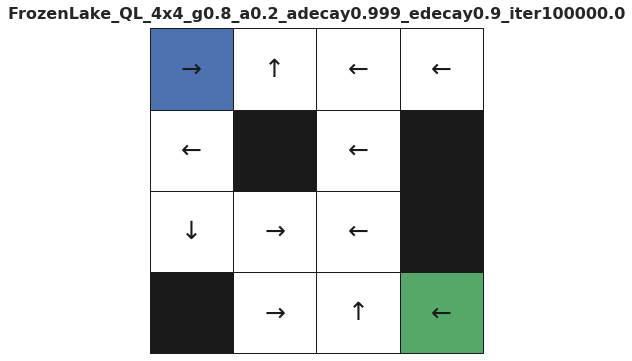

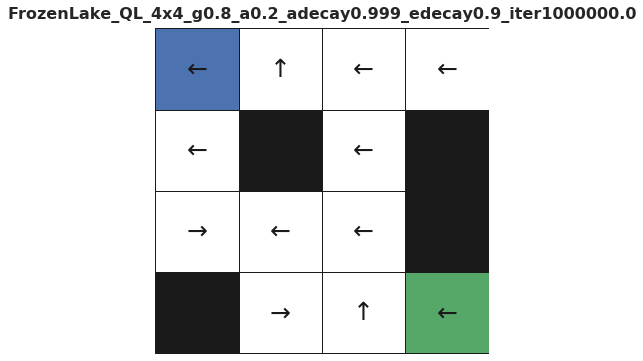

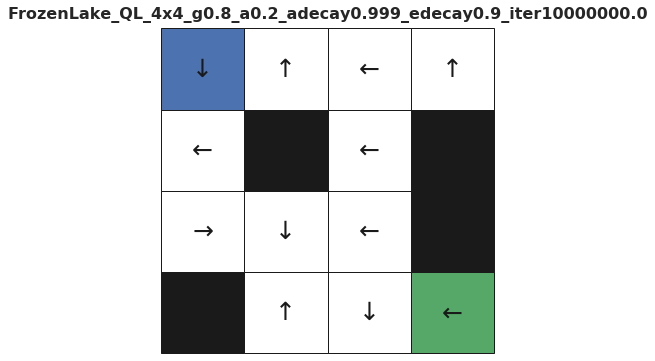

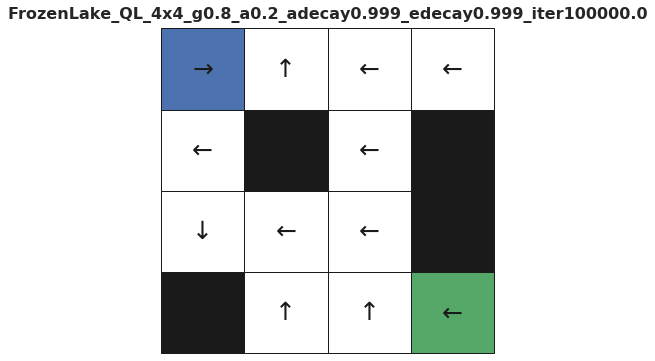

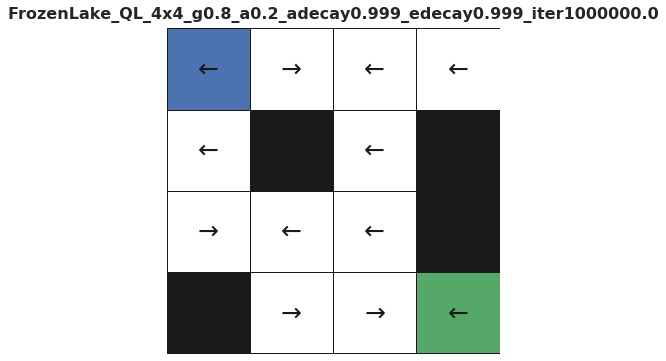

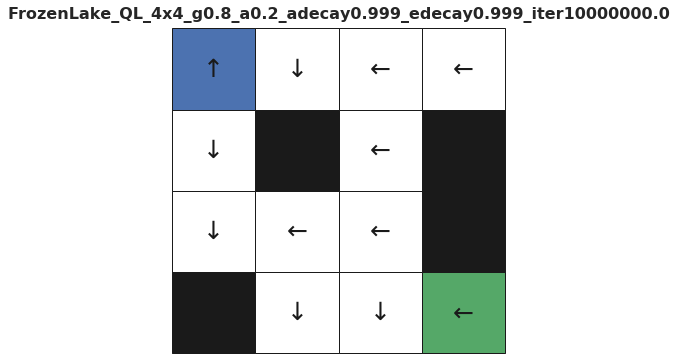

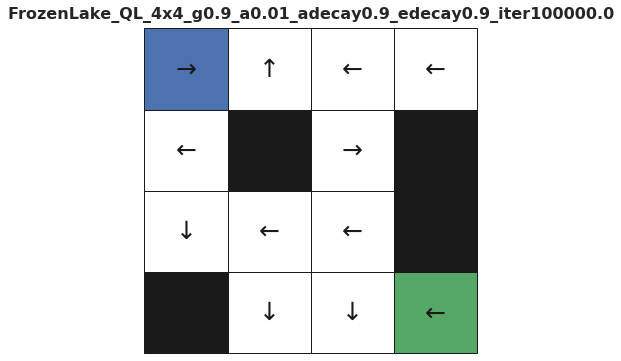

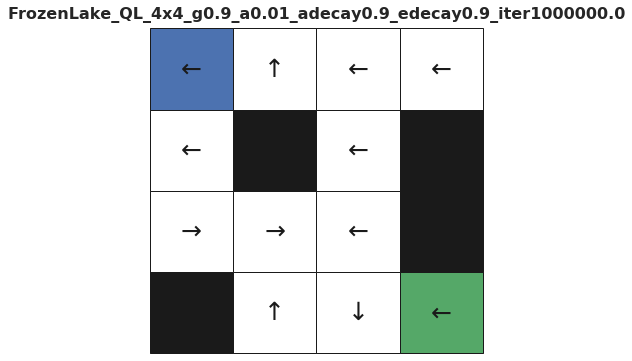

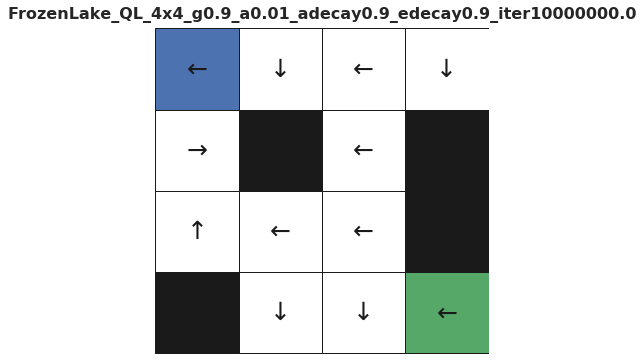

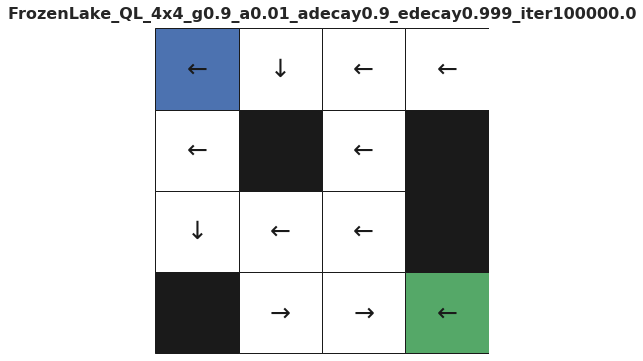

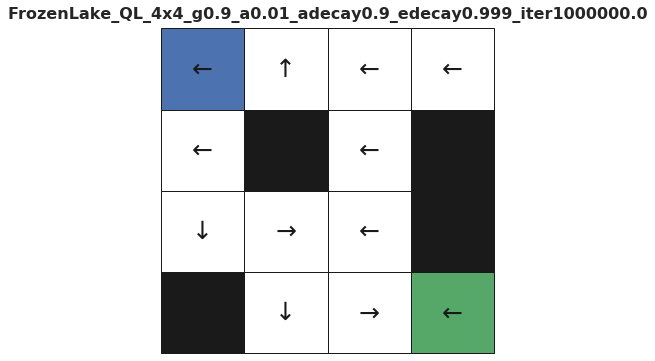

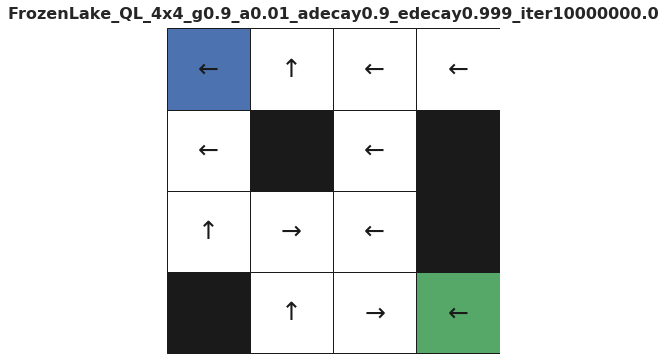

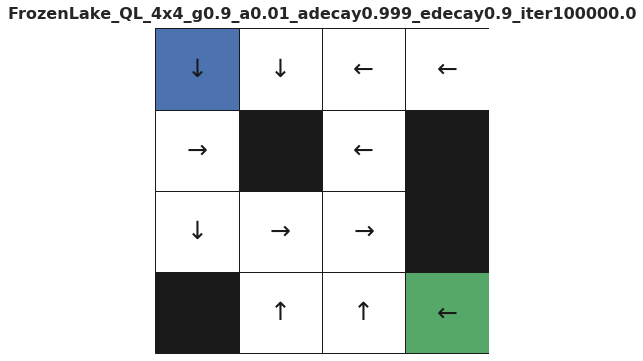

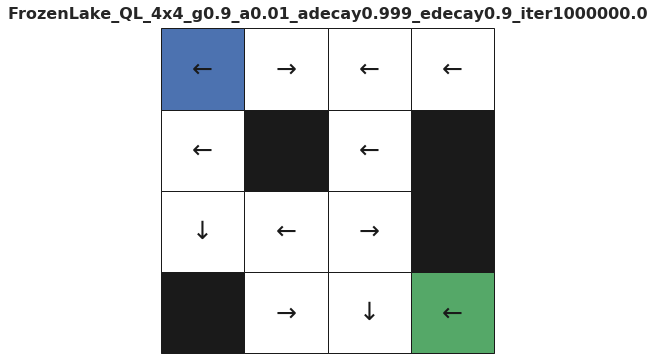

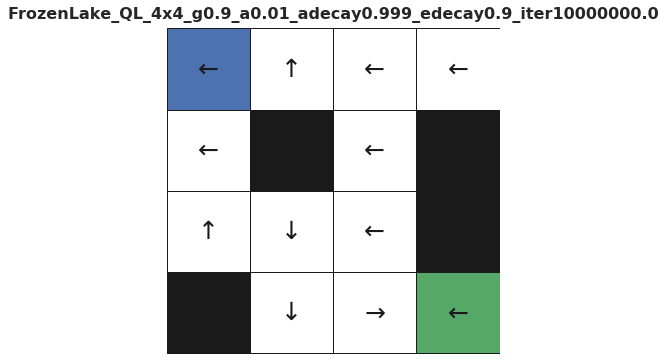

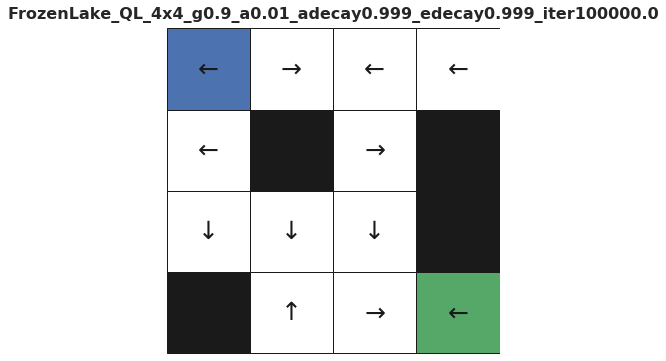

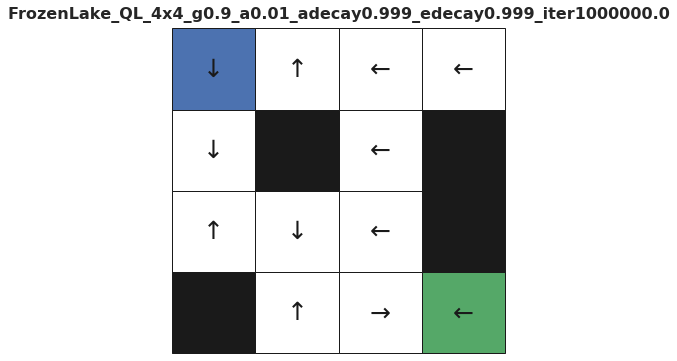

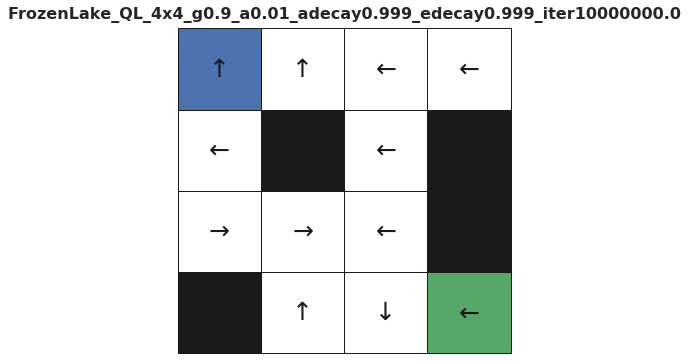

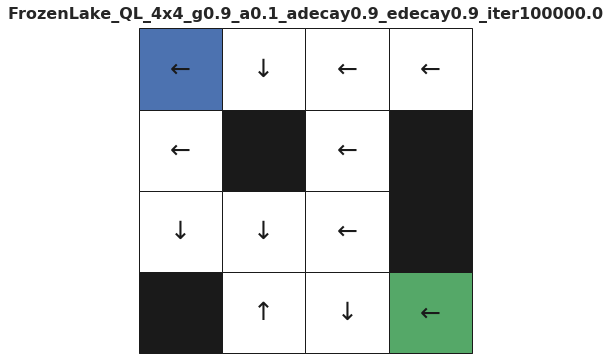

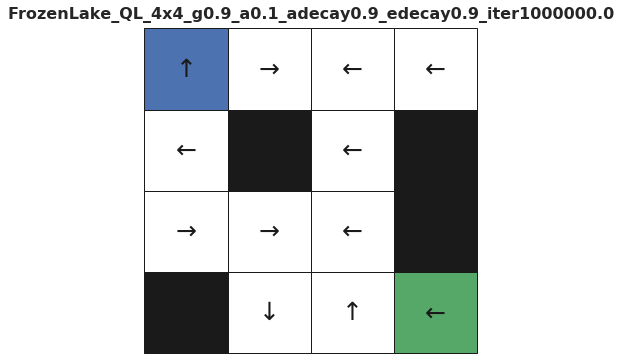

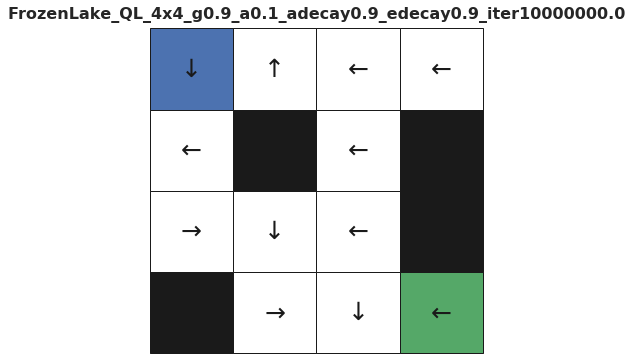

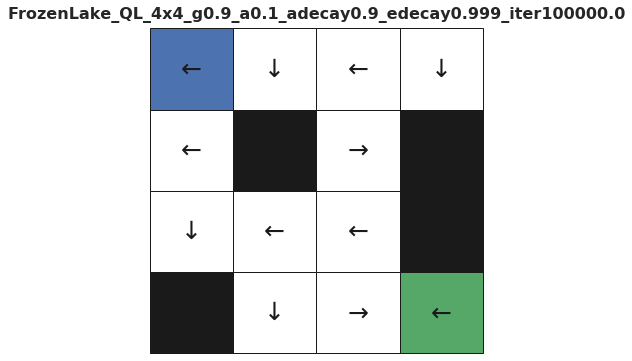

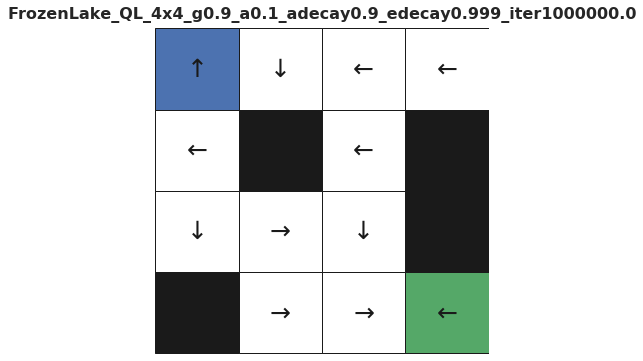

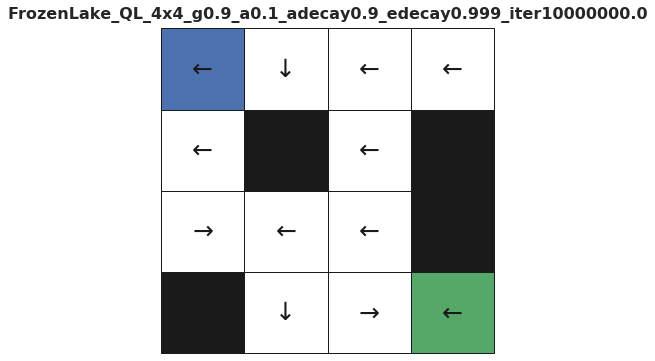

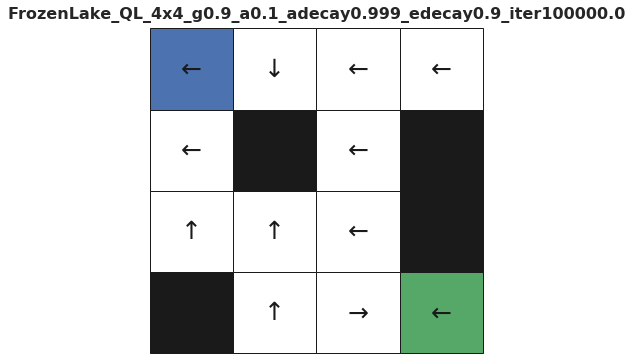

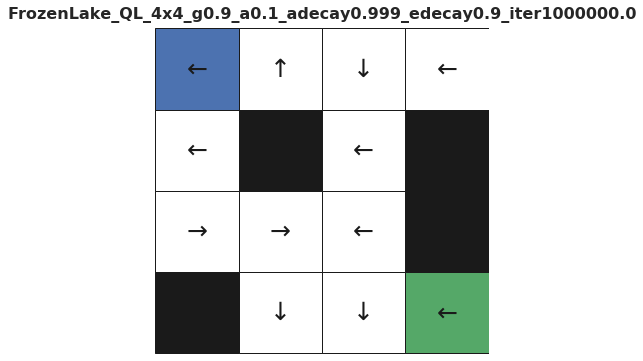

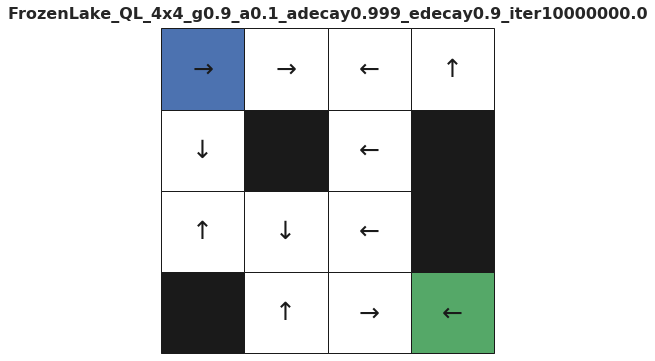

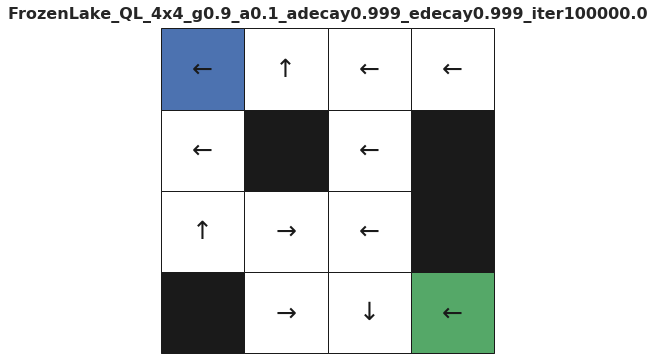

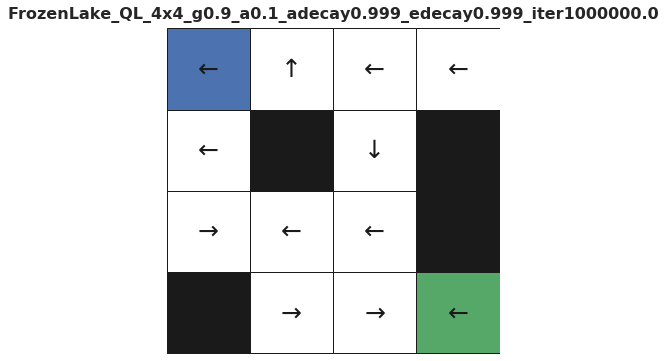

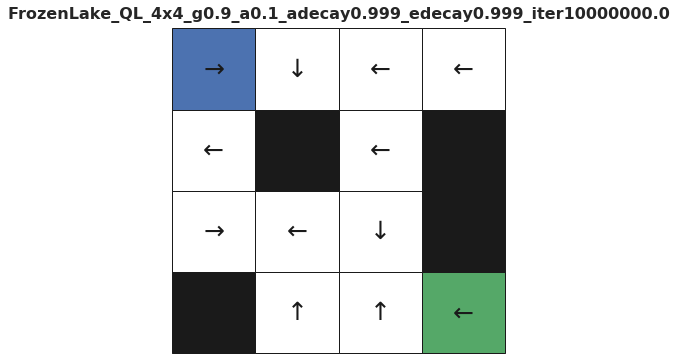

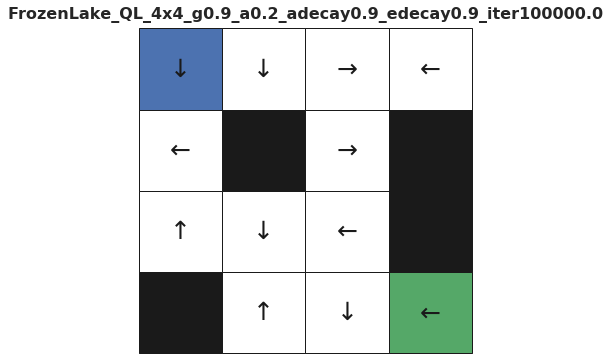

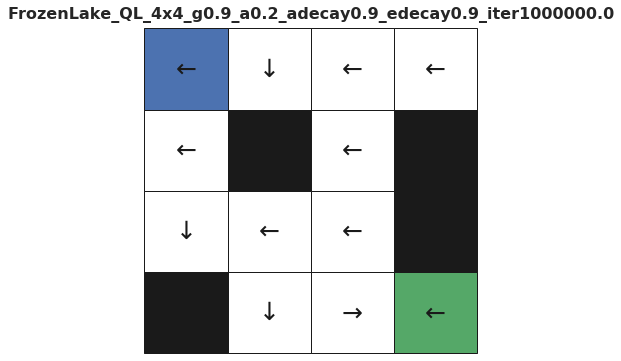

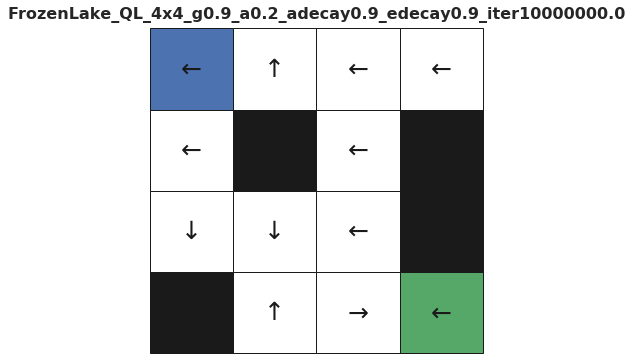

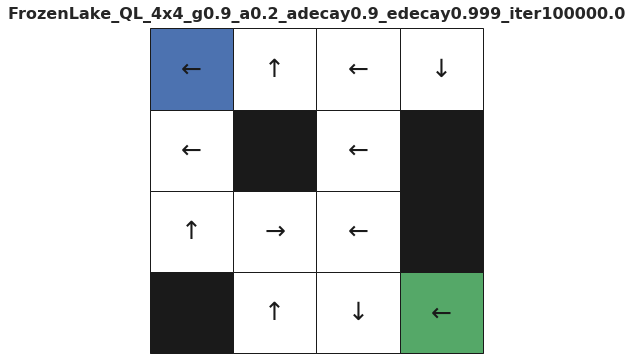

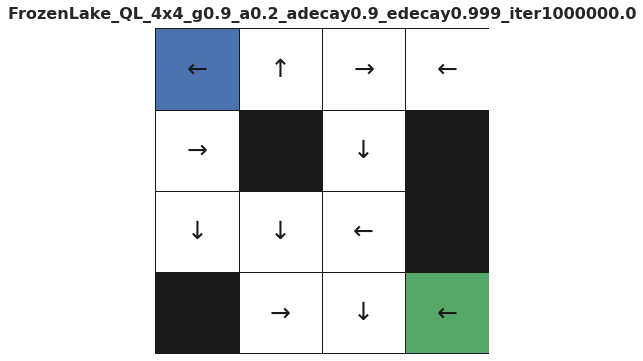

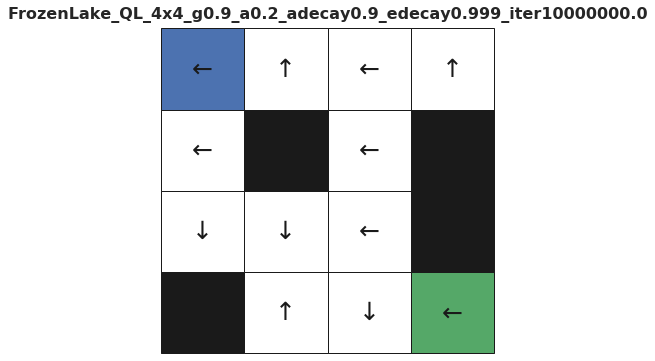

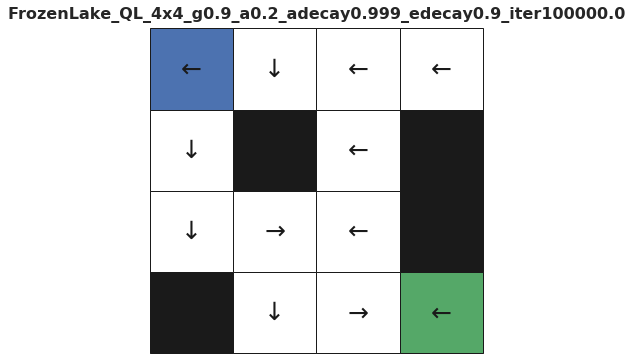

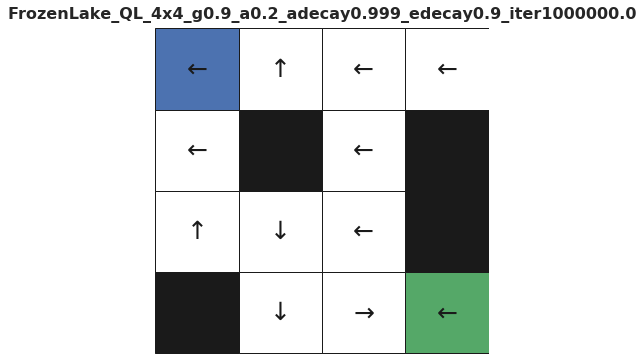

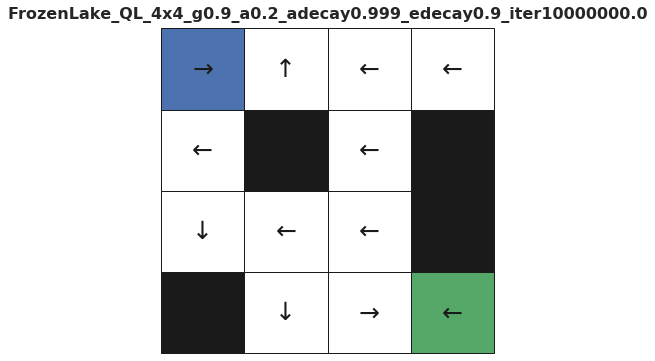

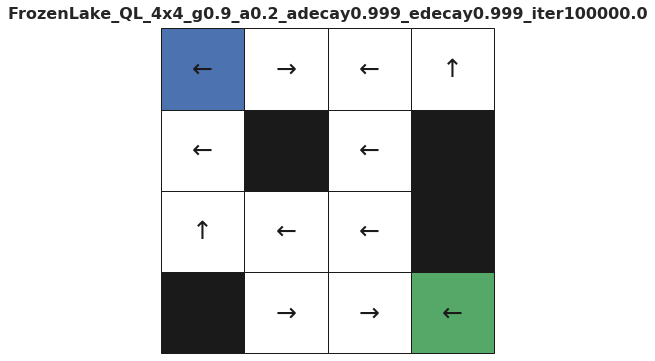

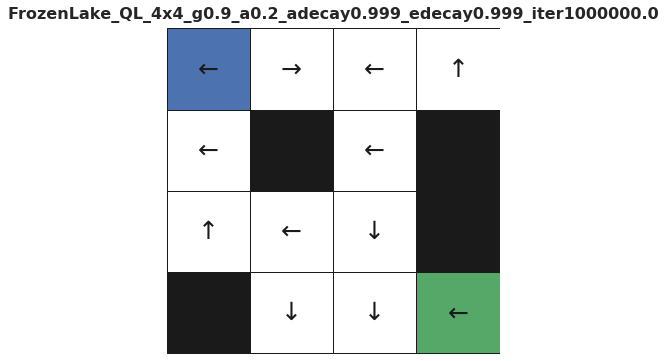

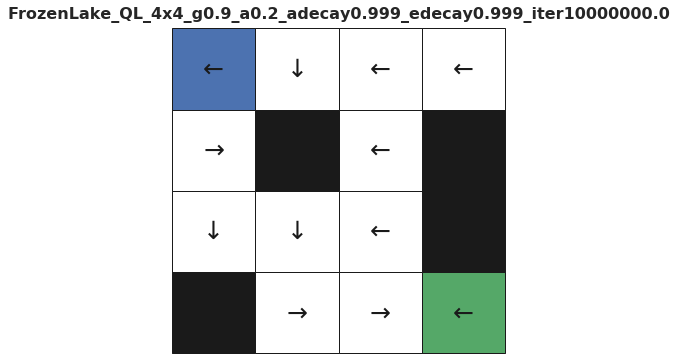

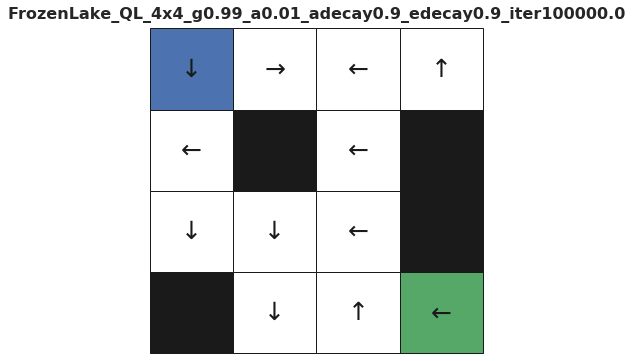

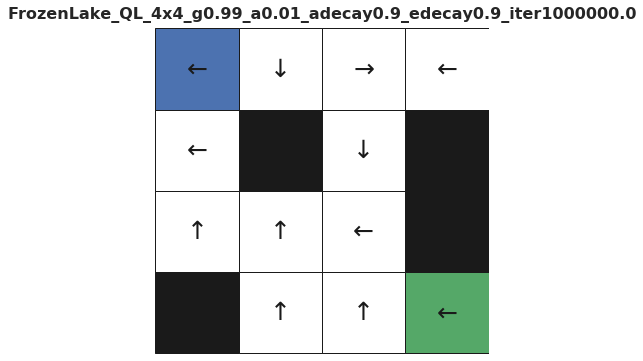

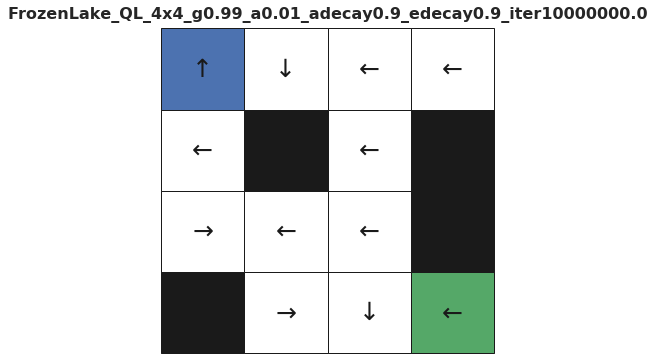

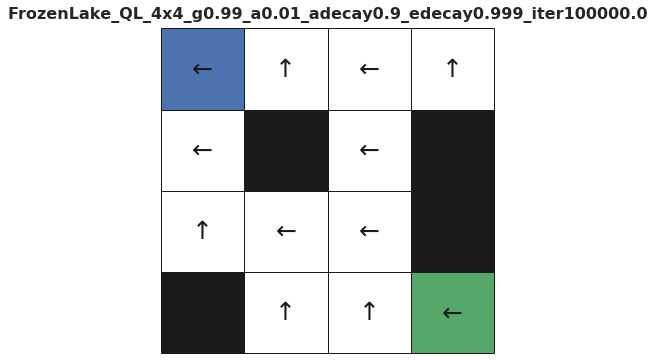

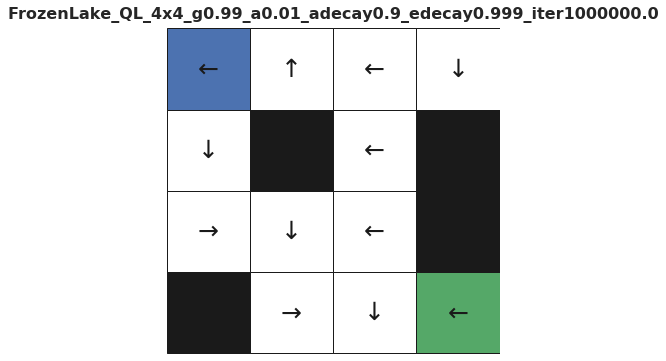

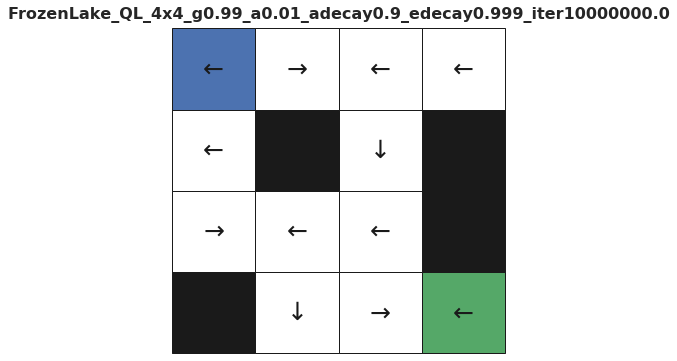

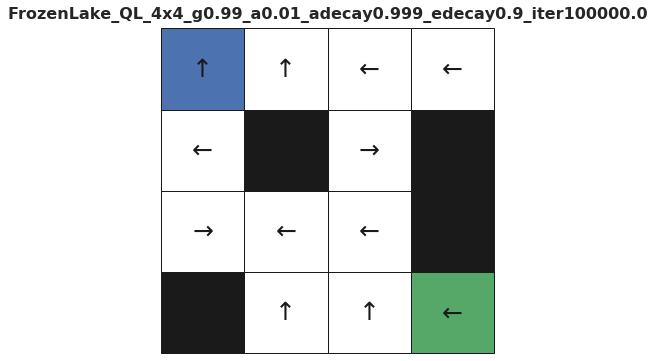

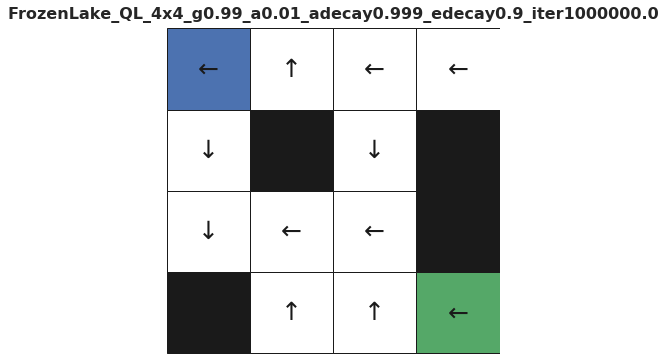

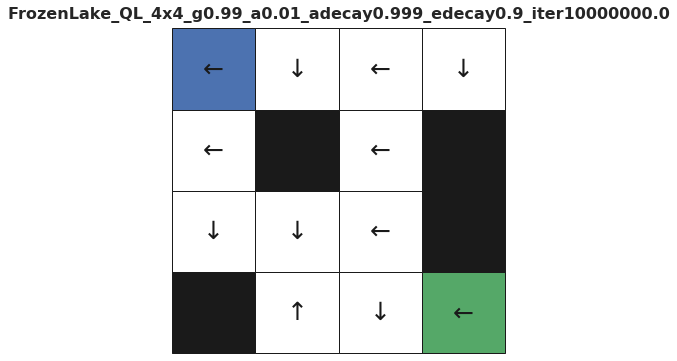

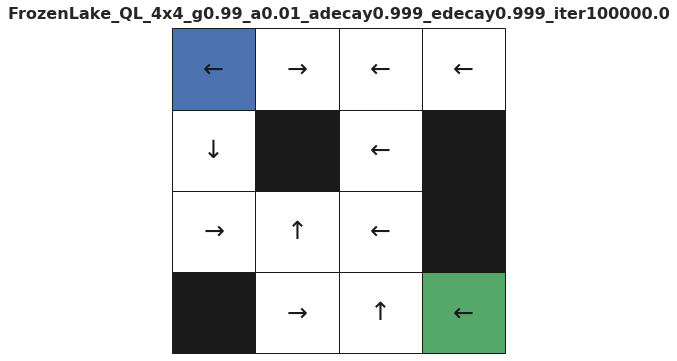

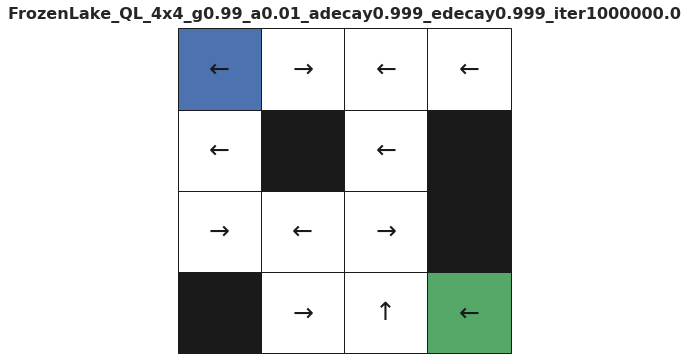

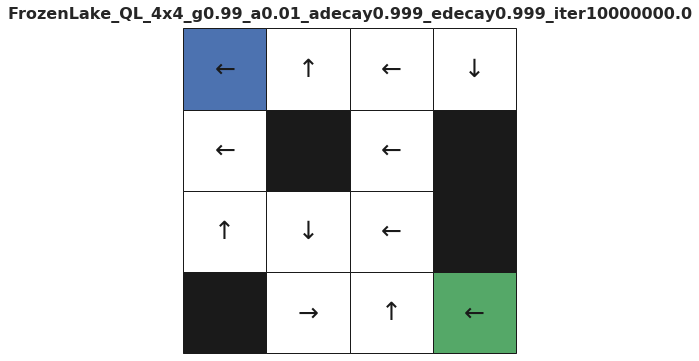

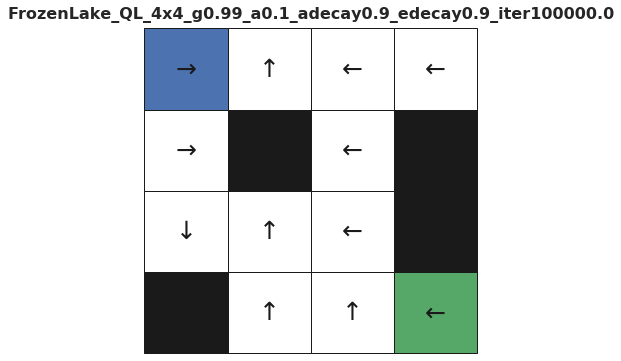

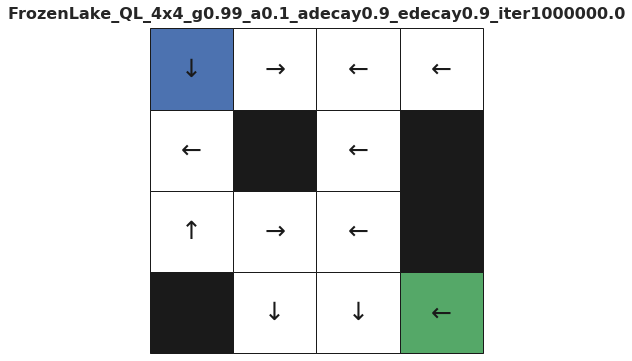

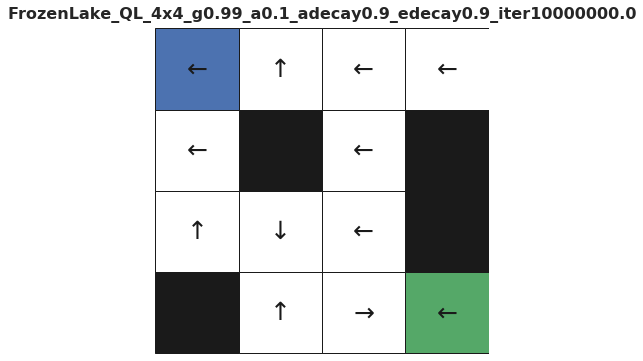

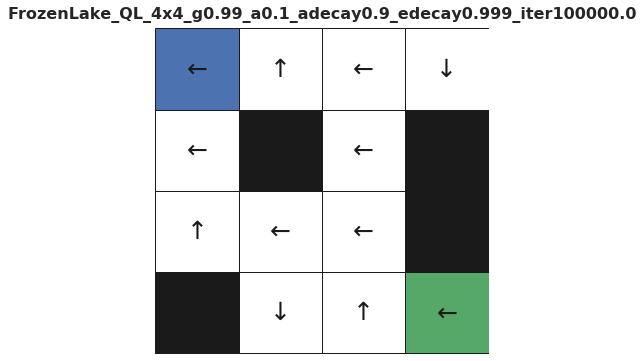

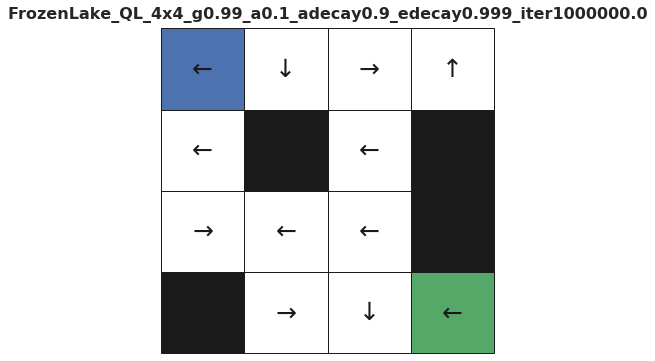

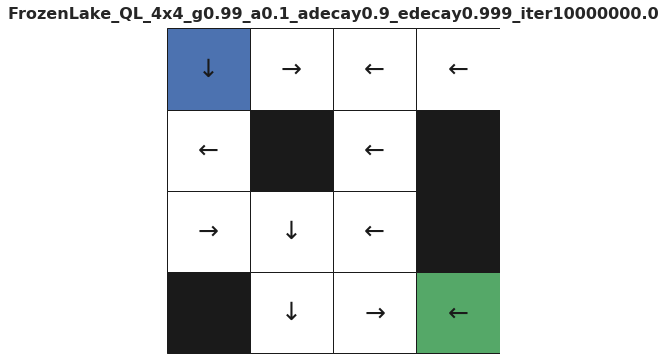

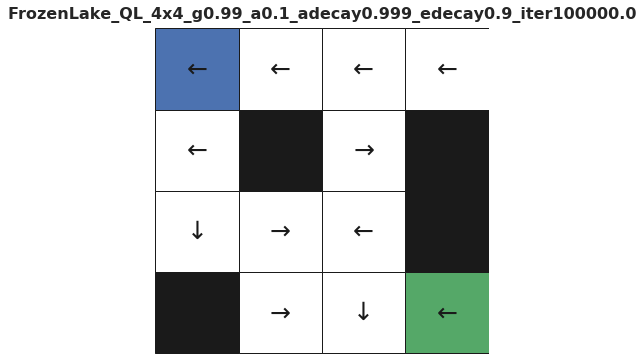

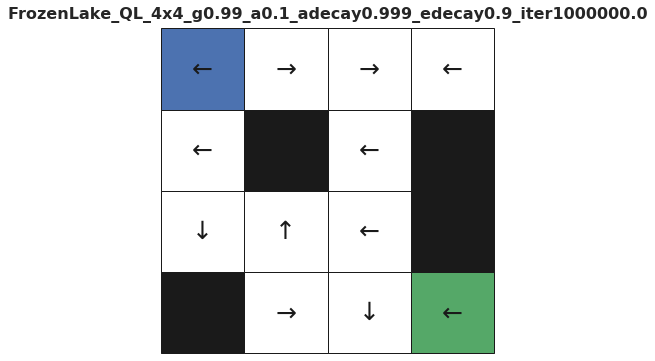

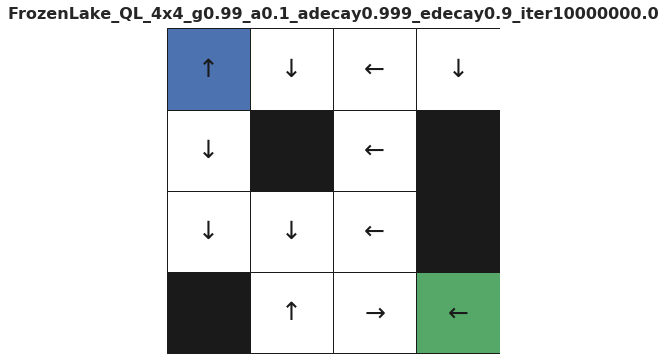

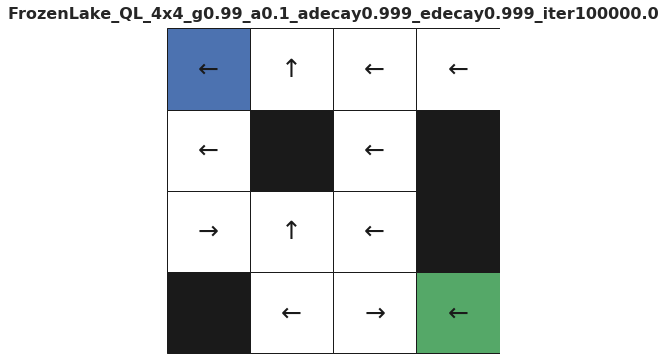

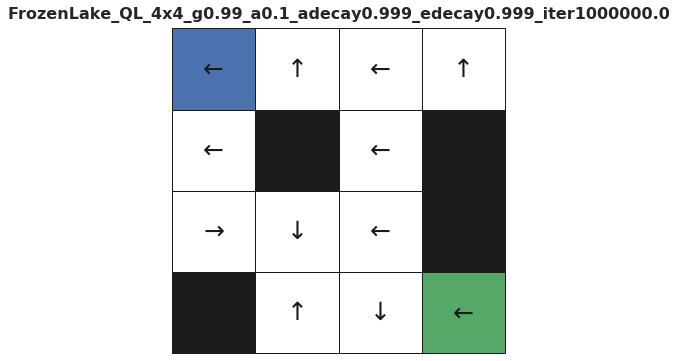

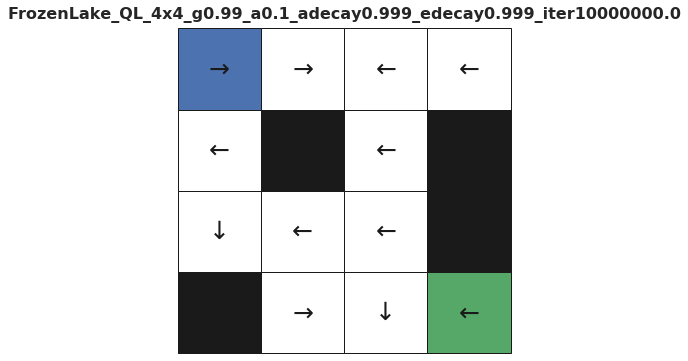

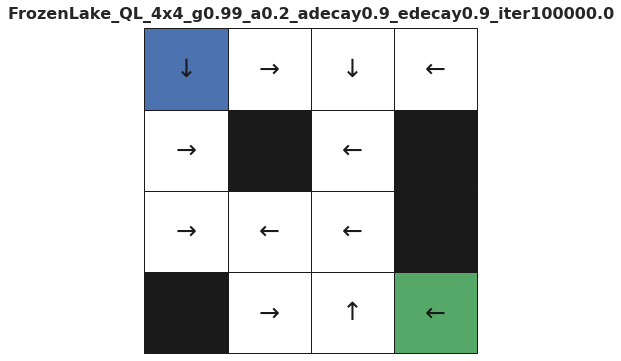

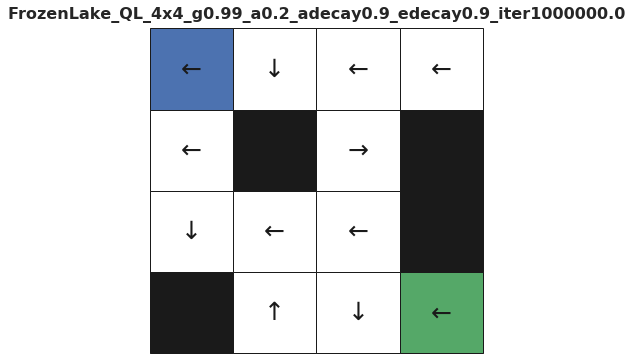

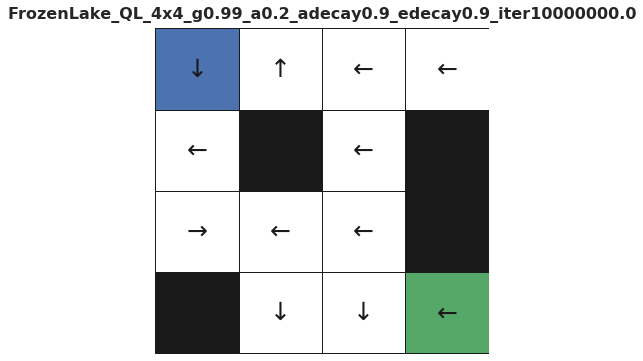

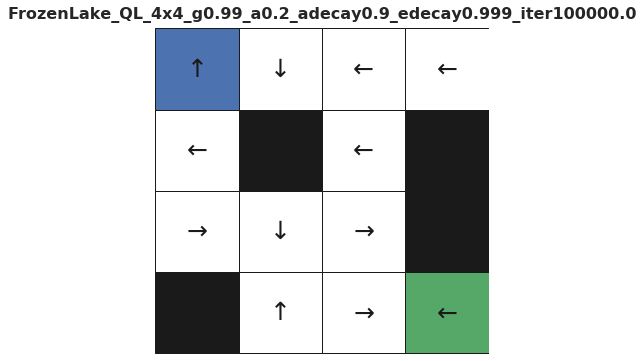

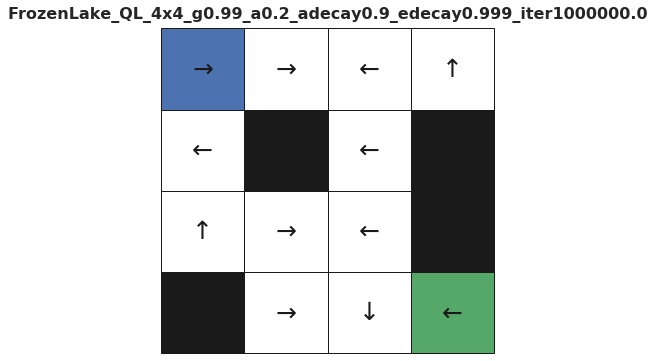

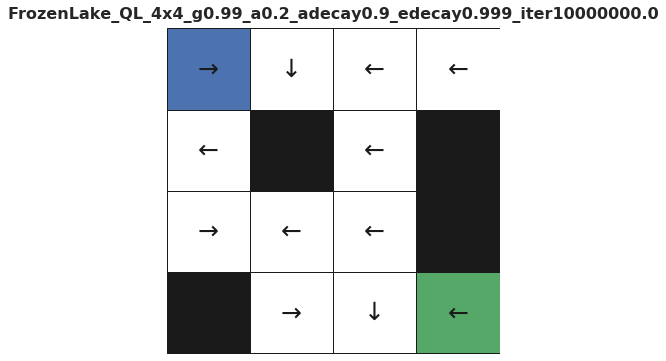

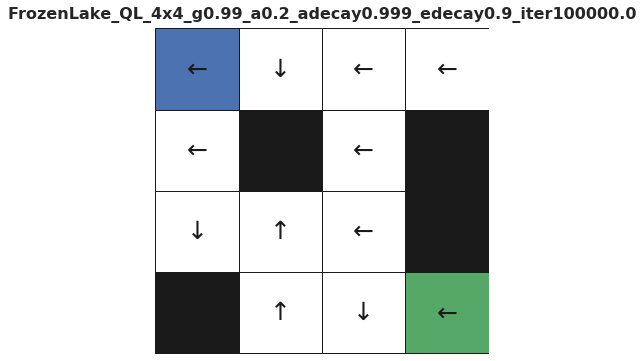

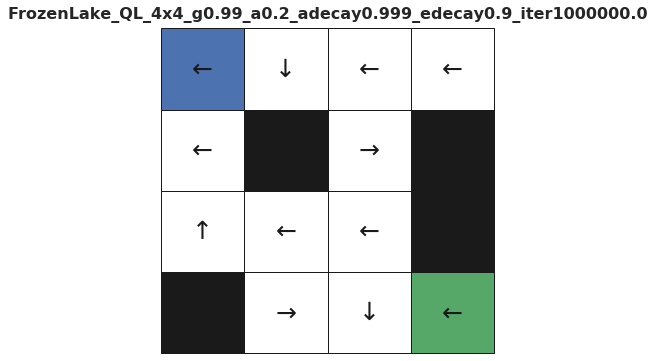

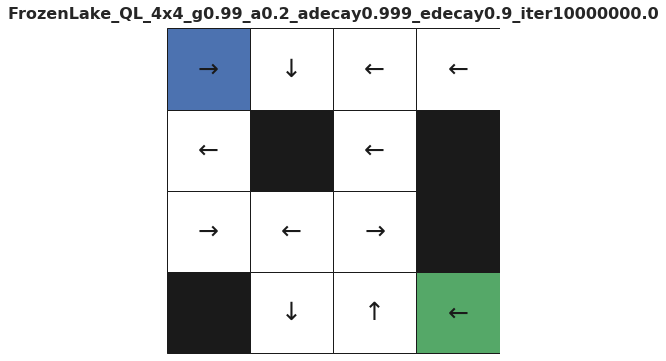

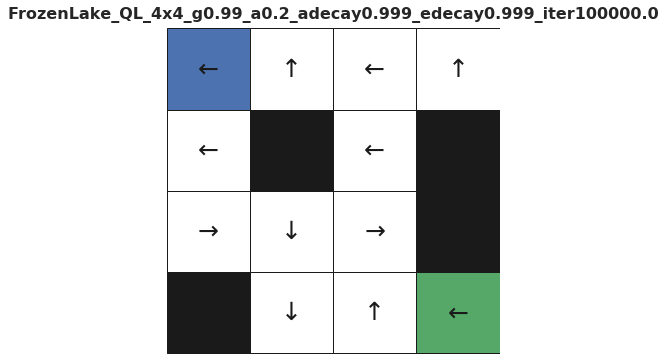

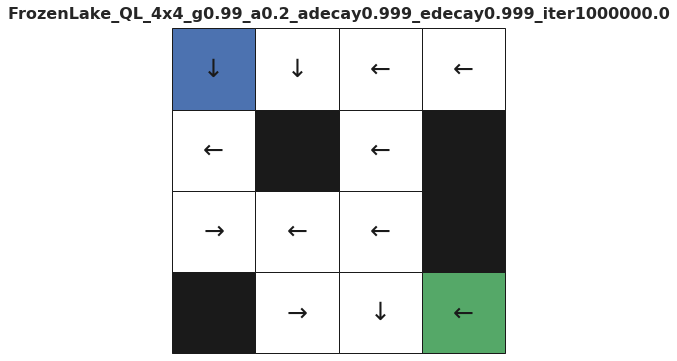

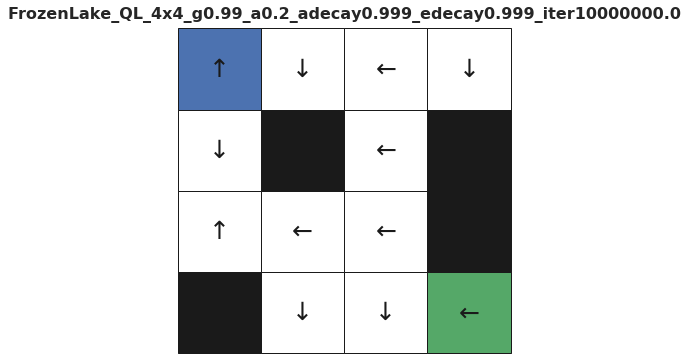

In [69]:
gammas   = [0.8, 0.9, 0.99]
alphas   = [0.01, 0.1, 0.2]
alpha_decays = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations = [1e5, 1e6, 1e7]

ql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=True)

# write all results to csv file
csvFile = 'frozen/QI_results.csv'
ql_data.to_csv(csvFile)

ql_data.head()


In [48]:
ql_data.head()

,gamma,alpha,time,iterations,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0.9,0.1,455.687366,10000000.0,0.635796,18.511811,10.076765,12.7,"{(2, 1, 0, 0, 2, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Plots

## Results

In [ ]:
# Plot most successful gamma

# find the score with the highest success percentage and get its policy
bestRun = pi_data['success_pct'].argmax()

best_policy = pi_data['policy'][bestRun]
best_policy = np.array(list(best_policy)[0])
best_policy = best_policy.reshape(rows, cols)

# plot the policy
title='Frozen Lake PI Optimal Policy'
plot_lake(env, best_policy, title)

print('Best Result:\n\tSuccess = %.2f\n\tGamma = %.2f' % (pi_data['success_pct'].max(), pi_data['gamma'][bestRun]))